In [1]:
import os
import json
from copy import copy
import pandas as pd
from sklearn.isotonic import spearmanr
from scipy.stats import kendalltau
import numpy as np

PROTEINS = os.listdir("results")
PROTEINS = [file.split("-dist")[0] for file in PROTEINS if file.endswith("distances.json")]
EMBEDDINGS = ["grasr-cosine", "grasr-euclidean", "pca-cosine", "pca-euclidean", "zirke-euclidean", "zirke-cosine", "lmi-euclidean", "lmi-cosine", "lmi-30-euclidean", "lmi-30-cosine"]
EMBEDDINGS_LEGEND = ["GraSR (E)", "GraSR (C)", "PCA-reduced GraSR (E)", "PCA-reduced GraSR (C)", "3D-af-Surfer (E)", "3D-af-Surfer (C)", "LMI-10 (E)", "LMI-10 (C)", "LMI-30 (E)", "LMI-30 (C)"]

def compute_correlation(file1, file2, protein_filter=None, use_kendal=False) -> float:
    """
    Compute spearman and pearson correlation between two json files.

    Args:
        file1 (str): path to first json file
        file2 (str): path to second json file
        protein_filter (list, optional): list of proteins, if not None, correlation will be computed
            only from provided list.

    Returns:
        float: spearman correlation
    """
    with open(file1) as file:
        json_x = json.load(file)
    with open(file2) as file:
        json_y = json.load(file)

    if protein_filter:
        json_x = {k: v for k, v in json_x.items() if k in protein_filter}
        json_y = {k: v for k, v in json_y.items() if k in protein_filter}

    rank_x = copy(json_x)
    rank_y = copy(json_y)
    for i, key in enumerate(json_x):
        rank_x[key] = i
        rank_y[key] = i

    if use_kendal:
        kendal = kendalltau(list(rank_x.values()), list(rank_y.values()))
        return kendal.correlation

    spearman = spearmanr(list(rank_x.values()), list(rank_y.values()))
    return spearman.statistic


print("Proteins before filtering:", len(PROTEINS))
filtered_proteins = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json") as file:
        json_file = json.load(file)
        if list(json_file.values())[600] < 0.5:
            filtered_proteins.append(protein)
PROTEINS = filtered_proteins
print("Final sample size:", len(PROTEINS))

correlations = {}

for embedding in EMBEDDINGS_LEGEND:
    correlations[embedding] = {"spearman": [], "kendal": []}
for protein in PROTEINS:
    for i, embedding in enumerate(EMBEDDINGS):
        correlations[EMBEDDINGS_LEGEND[i]]["spearman"].append(compute_correlation(f"results/{protein}-distances.json", f"results/{protein}-distances-{embedding}.json"))
        correlations[EMBEDDINGS_LEGEND[i]]["kendal"].append(compute_correlation(f"results/{protein}-distances.json", f"results/{protein}-distances-{embedding}.json", use_kendal=True))

correlations_df = [
    (
        key,
        np.mean(value["spearman"]),
        np.std(value["spearman"]),
        np.mean(value["kendal"]),
        np.std(value["kendal"]),
    ) for (key, value) in correlations.items()
]

print("Correlation coefficients")
print(pd.DataFrame(correlations_df, columns=["embedding", "spearman", "stdev", "kendal", "stdev"]).sort_values(by="spearman", ascending=False))

Proteins before filtering: 100
Final sample size: 73
Correlation coefficients
               embedding  spearman     stdev    kendal     stdev
5       3D-af-Surfer (C)  0.627622  0.180300  0.469832  0.146798
4       3D-af-Surfer (E)  0.624372  0.177585  0.463552  0.144341
2  PCA-reduced GraSR (E)  0.568197  0.213038  0.404468  0.156548
1              GraSR (C)  0.555140  0.204681  0.392053  0.149333
3  PCA-reduced GraSR (C)  0.555140  0.204681  0.392053  0.149333
0              GraSR (E)  0.555139  0.204681  0.392053  0.149333
7             LMI-10 (C)  0.283523  0.184682  0.199644  0.130801
6             LMI-10 (E)  0.243650  0.203581  0.166854  0.140760
8             LMI-30 (E)  0.243541  0.166372  0.172374  0.121971
9             LMI-30 (C)  0.174998  0.251799  0.118283  0.173437


In [2]:
import numpy as np


def binary_classification(ground_truth_file, evaluate_file, offset_x=0, threshold=None):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = np.median(list(json_x.values()))
    y_threshold = np.median(list(json_y.values()))

    if threshold:
        index = next((i for i, v in enumerate(list(json_x.values())) if v > threshold), len(json_x) - 1)
        x_threshold = list(json_x.values())[index]
        y_threshold = list(json_y.values())[index]
    
    if offset_x == 0:
        offset_y = 0
    else:
        index_lower = next((i for i, v in enumerate(list(json_x.values())) if v > x_threshold-offset_x), len(json_x) - 1)
        index_upper = next((i for i, v in enumerate(list(json_x.values())) if v > x_threshold+offset_x), len(json_x) - 1)
        offset_y = (list(json_y.values())[index_upper] - list(json_y.values())[index_lower]) / 2

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold - offset_x and json_y[key] < y_threshold - offset_y:
            true_positive += 1
        elif json_x[key] >= x_threshold + offset_x and json_y[key] < y_threshold - offset_y:
            false_positive += 1
        elif json_x[key] < x_threshold - offset_x and json_y[key] >= y_threshold + offset_y:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "precision": 0,
            "recall": 0,
        }
    return {
            "precision": true_positive / (true_positive + false_positive),
            "recall": true_positive / (true_positive + false_negative),
        }

median_classification = []
offseted_classification = []

for protein in PROTEINS:
    for i, embedding in enumerate(EMBEDDINGS):
        median_classification.append(
            (EMBEDDINGS_LEGEND[i],
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                threshold=0.5,
            ))
        )
        offseted_classification.append(
            (EMBEDDINGS_LEGEND[i],
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                offset_x=0.1,
                threshold=0.5,
            ))
        )

median_classification = [(emb, result["precision"], result["recall"]) for emb, result in median_classification]
median_classification = pd.DataFrame(median_classification, columns=["config", "precision", "recall"])

offseted_classification = [(emb, result["precision"], result["recall"]) for emb, result in offseted_classification]
offseted_classification = pd.DataFrame(offseted_classification, columns=["config", "precision", "recall"])


print("Classification at 0.5")
print(median_classification.groupby("config").mean().sort_values(by="precision", ascending=False))
print("\nClassification with a cut-off")
print(offseted_classification.groupby("config").mean().sort_values(by="precision", ascending=False))

Classification at 0.5
                       precision    recall
config                                    
3D-af-Surfer (E)        0.769739  0.769739
3D-af-Surfer (C)        0.755490  0.755490
PCA-reduced GraSR (E)   0.704798  0.704798
GraSR (C)               0.704368  0.704368
GraSR (E)               0.704368  0.704368
PCA-reduced GraSR (C)   0.704368  0.704368
LMI-10 (C)              0.568995  0.568995
LMI-30 (C)              0.549523  0.549523
LMI-10 (E)              0.506910  0.506910
LMI-30 (E)              0.506473  0.506473

Classification with a cut-off
                       precision    recall
config                                    
3D-af-Surfer (E)        0.823812  0.817937
3D-af-Surfer (C)        0.815017  0.811102
PCA-reduced GraSR (E)   0.764423  0.754514
GraSR (E)               0.764289  0.757239
GraSR (C)               0.763857  0.758080
PCA-reduced GraSR (C)   0.763857  0.758080
LMI-10 (C)              0.595143  0.604599
LMI-30 (C)              0.562540  0.560614
L

             config       AUC
5      zirke-cosine  0.822164
4   zirke-euclidean  0.815050
2        pca-cosine  0.777463
1   grasr-euclidean  0.765727
0      grasr-cosine  0.765727
3     pca-euclidean  0.765727
8  lmi-30-euclidean  0.673973
7        lmi-cosine  0.668728
6     lmi-euclidean  0.661241
9     lmi-30-cosine  0.614621


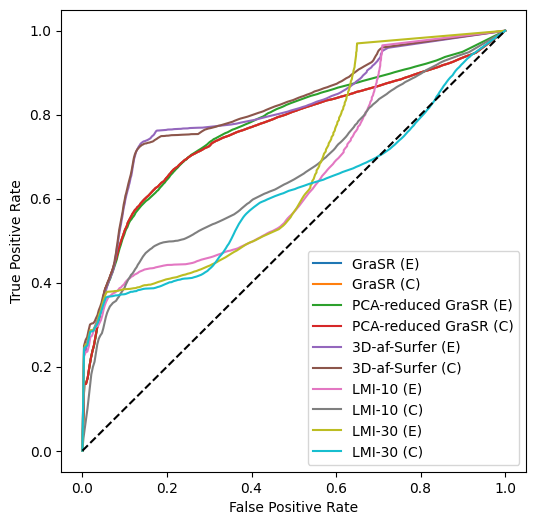

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def binary_classification(ground_truth_file, evaluate_file, index):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = list(json_x.values())[index]
    y_threshold = list(json_y.values())[index]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold and json_y[key] < y_threshold:
            true_positive += 1
        elif json_x[key] >= x_threshold and json_y[key] < y_threshold:
            false_positive += 1
        elif json_x[key] < x_threshold and json_y[key] >= y_threshold:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "tpr": 0,
            "fpr": 0,
        }
    return {
            "tpr": true_positive / (true_positive + false_negative),
            "fpr": false_positive / (false_positive + true_negative),
        }

precision_recall = {}
auc = {}
map = {}

for embedding in EMBEDDINGS:
    precision_recall[embedding] = []
    for i in range(0, 1900//10):
        precision_recall[embedding].append([])

for protein in PROTEINS:
    for embedding in EMBEDDINGS:
        for i in range(0, 1900, 10):
            precision_recall[embedding][i//10].append(
                binary_classification(
                    f"results/{protein}-distances.json",
                    f"results/{protein}-distances-{embedding}.json",
                    index=i,
                )
            )

for embedding in EMBEDDINGS:
    average_fpr = [[v["fpr"] for v in l] for l in precision_recall[embedding]]
    average_tpr = [[v["tpr"] for v in l] for l in precision_recall[embedding]]

    average_fpr = np.mean(average_fpr, axis=1)
    average_tpr = np.mean(average_tpr, axis=1)
    average_fpr = list(average_fpr) + [1]
    average_tpr = list(average_tpr) + [1]
    # sort
    average_fpr = sorted(average_fpr)
    average_tpr = sorted(average_tpr)

    plt.plot(average_fpr, average_tpr)

    auc_score = 0
    for i in range(1, len(average_fpr)):
        auc_score += (average_fpr[i] - average_fpr[i-1]) * average_tpr[i]
    auc[embedding] = auc_score

print(pd.DataFrame(auc.items(), columns=["config", "AUC"]).sort_values(by="AUC", ascending=False))

plt.legend(EMBEDDINGS_LEGEND)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.gcf().set_size_inches(6, 6)
plt.show()


In [4]:
import numpy as np

def average_precision(ground_truth_file, evaluate_file, threshold, cutoff=False):
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)
    
    if cutoff:
        # remove proteins with tm-score 0.4-0.6
        json_x = {k: v for k, v in json_x.items() if v < 0.4 or v > 0.6}
        json_y = {k: v for k, v in json_y.items() if k in json_x}
    x_true = [k for k, v in json_x.items() if v < threshold]
    y_true = [1 if k in x_true else 0 for k, v in json_y.items()]

    precision = []
    recall = []
    for i in range(1, len(x_true)):
        precision.append(sum(y_true[:i]) / i)
        recall.append(sum(y_true[:i]) / sum(y_true))
    
    return sum([precision[i] * (recall[i] - recall[i-1]) for i in range(1, len(precision))])

mean_ap_04 = {}
mean_ap_05 = {}
for embedding in EMBEDDINGS:
    mean_ap_05[embedding] = []
    mean_ap_04[embedding] = []

for embedding in EMBEDDINGS:
    for protein in PROTEINS:
        mean_ap_04[embedding].append(
            average_precision(
                f"results/{protein}-distances.json",
                f"results/{protein}-distances-{embedding}.json",
                0.4,
                cutoff=True,
            )
        )
        mean_ap_05[embedding].append(
            average_precision(
                f"results/{protein}-distances.json",
                f"results/{protein}-distances-{embedding}.json",
                0.5,
            )
        )
mean_ap_04_df = {(k, np.mean(v), np.std(v)) for k, v in mean_ap_04.items()}
mean_ap_05_df = {(k, np.mean(v), np.std(v)) for k, v in mean_ap_05.items()}
print("Mean average precision for threshold 0.4 with cutoff")
print(pd.DataFrame(mean_ap_04_df, columns=["config", "mAP", "std"]).sort_values(by="mAP", ascending=False))

print("\nMean average precision for threshold 0.5")
print(pd.DataFrame(mean_ap_05_df, columns=["config", "mAP", "std"]).sort_values(by="mAP", ascending=False))


Mean average precision for threshold 0.4 with cutoff
             config       mAP       std
6   zirke-euclidean  0.747682  0.180438
0      zirke-cosine  0.736005  0.169252
4   grasr-euclidean  0.652521  0.144826
1     pca-euclidean  0.652521  0.144826
9      grasr-cosine  0.652521  0.144826
8        pca-cosine  0.651442  0.148096
3     lmi-30-cosine  0.430062  0.176466
2        lmi-cosine  0.404200  0.132118
7     lmi-euclidean  0.393782  0.151898
5  lmi-30-euclidean  0.368181  0.128667

Mean average precision for threshold 0.5
             config       mAP       std
3   zirke-euclidean  0.715481  0.170336
7      zirke-cosine  0.700593  0.157303
5   grasr-euclidean  0.613638  0.138397
4     pca-euclidean  0.613638  0.138397
6      grasr-cosine  0.613638  0.138397
9        pca-cosine  0.612966  0.140823
1     lmi-30-cosine  0.418371  0.165904
2        lmi-cosine  0.387816  0.121968
0     lmi-euclidean  0.373923  0.147141
8  lmi-30-euclidean  0.354924  0.126455


In [ ]:
protein_tierlist = zip(mean_ap_04["zirke-euclidean"], PROTEINS)
protein_tierlist = sorted(protein_tierlist, reverse=True)

# print with ranks
print("Best performers according to 3d-af-surfer\n")
for i, (ap, protein) in enumerate(protein_tierlist):
    print(f"{i+1}. {protein} {ap:.3f}")

Best performers according to 3d-af-surfer

1. AF-D7PBG5-F1 0.884
2. AF-A0A1C9EMC3-F1 0.882
3. AF-A0A159H638-F1 0.879
4. AF-A0A343XVU5-F1 0.876
5. AF-A0A386LLN3-F1 0.876
6. AF-A0A344VJA7-F1 0.876
7. AF-A0A482HPU1-F1 0.875
8. AF-A0A386III0-F1 0.875
9. AF-A0A2U8YU98-F1 0.874
10. AF-A0A385YFZ6-F1 0.873
11. AF-A0A2Z5F384-F1 0.871
12. AF-A0A2I6Q5N0-F1 0.870
13. AF-A0A343XV74-F1 0.866
14. AF-A0A1U9GUA8-F1 0.861
15. AF-A0A2S1ZX05-F1 0.860
16. AF-A0A2Z4ERT0-F1 0.859
17. AF-A0A0A0MDK1-F1 0.859
18. AF-A0A141L453-F1 0.858
19. AF-A0A159E4H8-F1 0.857
20. AF-A0A346KW05-F1 0.856
21. AF-A0A220H7Z7-F1 0.852
22. AF-A0A3G1V387-F1 0.852
23. AF-A0A291QNQ6-F1 0.850
24. AF-A0A220ECL4-F1 0.835
25. AF-A0A6C0R830-F1 0.835
26. AF-A0A2Z5CT11-F1 0.834
27. AF-A0A3B8DT12-F1 0.826
28. AF-A0A6M8P3J6-F1 0.824
29. AF-A0A6G7HAL4-F1 0.824
30. AF-A0A2U9QQQ4-F1 0.822
31. AF-A0A3G1XEI5-F1 0.822
32. AF-A0A0M3LTA8-F1 0.821
33. AF-A0A0A0QIR8-F1 0.819
34. AF-H6B5E7-F1 0.816
35. AF-H6YZH9-F1 0.815
36. AF-B8XWA5-F1 0.812
37. AF-A0A

TM-distance density


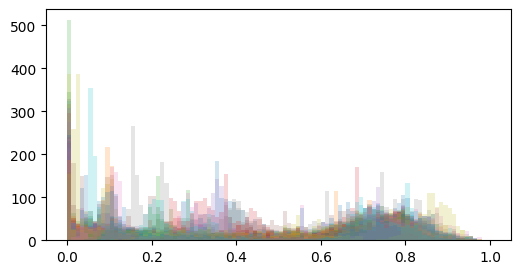

In [7]:
jsons = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        jsons.append(json.load(f))
for file in jsons:
    plt.hist(file.values(), bins=100, range=(0,1), alpha=0.2)

plt.gcf().set_size_inches(6, 3)

print("TM-distance density")
plt.show()

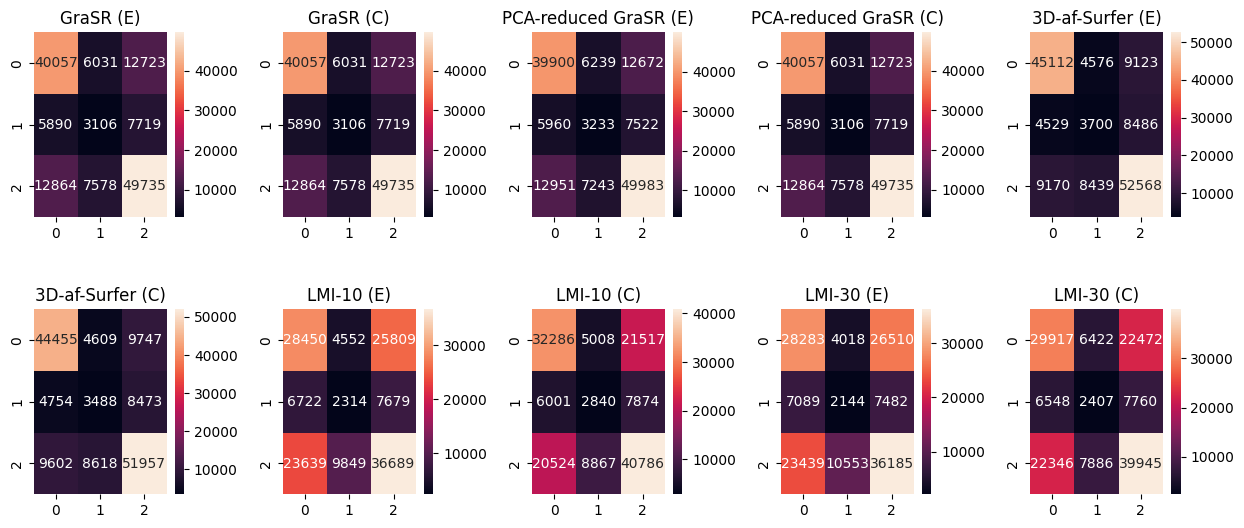

In [15]:
# confusion matrix for 3 classes

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy


protein = "AF-A0A2U9QQQ4-F1"
y_trues = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        y_true = json.load(f)


    ranges = [(0, 0.4), (0.4, 0.6), (0.6, 1)]
    for i, (start, end) in enumerate(ranges):
        for key, value in y_true.items():
            if start <= value < end:
                y_true[key] = i
    
    y_trues.append(copy(y_true))

# flatten y_trues.values
y_trues_flat = [list(y_true.values()) for y_true in y_trues]
y_trues_flat = [item for sublist in y_trues_flat for item in sublist]

for index, embedding in enumerate(EMBEDDINGS):
    jsons = []
    for protein in PROTEINS:
        with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
            jsons.append(json.load(f))

    y_pred = []
    for i, file in enumerate(jsons):
        for key in file.keys():
            y_pred.append(y_trues[i][key])

    # create a subplot
    plt.subplot(2, 5, index+1)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    matrix = confusion_matrix(y_trues_flat, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(EMBEDDINGS_LEGEND[index])

plt.gcf().set_size_inches(15, 6) 
plt.show()

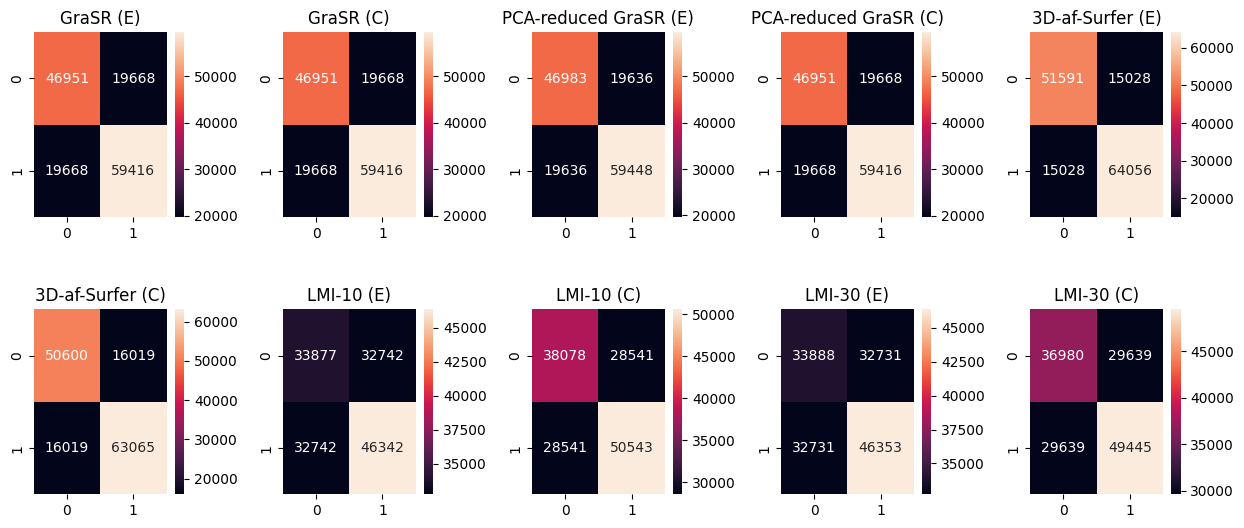

In [16]:
# confusion matrix for median

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
import numpy as np


protein = "AF-A0A2U9QQQ4-F1"
y_trues = []
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        y_true = json.load(f)

    #median = np.median(list(y_true.values()))
    median = 0.5
    ranges = [(0, median), (median, 1)]
    for i, (start, end) in enumerate(ranges):
        for key, value in y_true.items():
            if start <= value < end:
                y_true[key] = i
    
    y_trues.append(copy(y_true))

# flatten y_trues.values
y_trues_flat = [list(y_true.values()) for y_true in y_trues]
y_trues_flat = [item for sublist in y_trues_flat for item in sublist]

for index, embedding in enumerate(EMBEDDINGS):
    jsons = []
    for protein in PROTEINS:
        with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
            jsons.append(json.load(f))

    y_pred = []
    for i, file in enumerate(jsons):
        for key in file.keys():
            y_pred.append(y_trues[i][key])

    # create a subplot
    plt.subplot(2, 5, index+1)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    matrix = confusion_matrix(y_trues_flat, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(EMBEDDINGS_LEGEND[index])

plt.gcf().set_size_inches(15, 6) 
plt.show()